<p style="font-family: Arial; font-size:3.75vw;color:purple; font-style:bold"><br>
Prueba Meli
</p><br>

## 1. Recolección de Información

In [45]:
import requests
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeClassifier
from sklearn.preprocessing import StandardScaler

In [136]:
#categorías de meli en Colombia
cats = requests.get('https://api.mercadolibre.com/sites/MCO/categories')
prueba = cats.json()
df = pd.DataFrame(prueba)
df.head()

,id,name
0,MCO1747,Accesorios para Vehículos
1,MCO441917,Agro
2,MCO1403,Alimentos y Bebidas
3,MCO1071,Animales y Mascotas
4,MCO1367,Antigüedades y Colecciones


In [137]:
# Se trae la información de los primeros 1000 items de cada categoría listada en 'cats'
# MCO1039 camaras y accesorios
# MCO1648 computacion
# MCO1000 Electrónica, Audio y Video

cats = ['MCO1000', 'MCO1039', 'MCO1648']
list_offset = [i*50 for i in range(0,20)]

df_cats = pd.DataFrame()

for cat_id in cats:
    
    df_item = pd.DataFrame()
    for offset in list_offset:
        url = f'https://api.mercadolibre.com/sites/MCO/search?category={cat_id}&offset={offset}'
        request = requests.get(url)
        item = request.json()
        df = pd.DataFrame(item['results'])
        df_item = df_item.append(df)
    df_cats = df_cats.append(df_item)

In [139]:
df_cats.shape

(2997, 38)

In [140]:
df_cats.head(2)

,id,site_id,title,seller,price,prices,sale_price,currency_id,available_quantity,sold_quantity,...,tags,catalog_listing,use_thumbnail_id,offer_score,offer_share,match_score,winner_item_id,melicoin,order_backend,differential_pricing
0,MCO618049088,MCO,Audífonos Sony Zx Series Mdr-zx110 Negro,"{'id': 168810672, 'permalink': None, 'registra...",39900,"{'id': 'MCO618049088', 'prices': [{'id': '1', ...",None,COP,241,2053,...,"[good_quality_picture, loyalty_discount_eligib...",True,True,None,None,None,None,None,1,NaN
1,MCO810988443,MCO,Roku Express 3930 Estándar Full Hd 32mb Negro ...,"{'id': 323005693, 'permalink': None, 'registra...",130275,"{'id': 'MCO810988443', 'prices': [{'id': '23',...",None,COP,9,486,...,"[good_quality_picture, immediate_payment, cart...",True,True,None,None,None,None,None,2,NaN


In [5]:
df_cats.shape

(2938, 38)

In [515]:
#df_item.shape

#precios = pd.DataFrame(df['prices'][9]['prices'])
#precios['conditions'][0]

In [141]:
# lista de vendedores de los primeros mil productos de la categoría
vendedores = pd.DataFrame(df_cats['seller'].tolist())
unicos = pd.DataFrame(vendedores['id'].unique())
len(unicos)

771

In [7]:
df_sellers = pd.DataFrame()

for seller_id in vendedores['id'].unique():
    url = f'https://api.mercadolibre.com/sites/MCO/search?seller_id={seller_id}'
    request = requests.get(url)
    info_seller = request.json()
    
    inf_seller_1 = pd.DataFrame([info_seller['seller']])[['id','nickname','permalink','registration_date',
                                                            'real_estate_agency','car_dealer']]
    inf_seller_2 = pd.DataFrame([info_seller['seller']['seller_reputation']])[['level_id','power_seller_status']]
    inf_seller_3 = pd.DataFrame([info_seller['seller']['seller_reputation']['transactions']])[['canceled','period'
                                                                                           ,'total','completed']]
    inf_seller_4 = pd.DataFrame([info_seller['seller']['seller_reputation']['transactions']['ratings']])
    inf_seller_5 = pd.DataFrame([info_seller['seller']['seller_reputation']['metrics']['sales']])
    inf_seller_5.columns = ['last_period','last_completed']


    seller = pd.concat([inf_seller_1, inf_seller_2, inf_seller_3, inf_seller_4, inf_seller_5], axis=1)
    df_sellers = df_sellers.append(seller)

In [142]:
df_sellers.shape

(766, 17)

In [9]:
df_sellers.head(2)

,id,nickname,permalink,registration_date,real_estate_agency,car_dealer,level_id,power_seller_status,canceled,period,total,completed,negative,neutral,positive,last_period,last_completed
0,168810672,SONY COLOMBIA,http://perfil.mercadolibre.com.co/SONY+COLOMBIA,2014-10-14T12:03:55.000-04:00,False,False,5_green,platinum,1096,historic,22677,21581,0.02,0.02,0.96,60 days,3277
0,323005693,STREETGAMINGSTORE,http://perfil.mercadolibre.com.co/STREETGAMING...,2018-05-21T04:53:05.000-04:00,False,False,5_green,platinum,65,historic,1845,1780,0.00,0.00,1.00,60 days,313


In [20]:
#otra informacion que podria ser util

#paging = pd.DataFrame([info_seller['paging']])
#results = pd.DataFrame(info_seller['results'])
#sort = pd.DataFrame([info_seller['sort']])
#available_sorts = pd.DataFrame(info_seller['available_sorts'])
#filters = pd.DataFrame(info_seller['filters'])
#available_filters = pd.DataFrame(info_seller['available_filters'])

## 2. Exploración y limpieza Información

In [11]:
df_sellers.head(2)

,id,nickname,permalink,registration_date,real_estate_agency,car_dealer,level_id,power_seller_status,canceled,period,total,completed,negative,neutral,positive,last_period,last_completed
0,168810672,SONY COLOMBIA,http://perfil.mercadolibre.com.co/SONY+COLOMBIA,2014-10-14T12:03:55.000-04:00,False,False,5_green,platinum,1096,historic,22677,21581,0.02,0.02,0.96,60 days,3277
0,323005693,STREETGAMINGSTORE,http://perfil.mercadolibre.com.co/STREETGAMING...,2018-05-21T04:53:05.000-04:00,False,False,5_green,platinum,65,historic,1845,1780,0.00,0.00,1.00,60 days,313


In [91]:
df_sellers.isna().sum()

id                       0
nickname                 0
permalink                0
registration_date        0
real_estate_agency       0
car_dealer               0
level_id                 0
power_seller_status    106
canceled                 0
period                   0
total                    0
completed                0
negative                 0
neutral                  0
positive                 0
last_period              0
last_completed           0
dtype: int64

In [145]:
#eliminamos las variables con valor constante
prueba = df_sellers.loc[:,df_sellers.apply(pd.Series.nunique) != 1]
prueba.head(2)

,id,nickname,permalink,registration_date,level_id,power_seller_status,canceled,total,completed,negative,neutral,positive,last_period,last_completed
0,168810672,SONY COLOMBIA,http://perfil.mercadolibre.com.co/SONY+COLOMBIA,2014-10-14T12:03:55.000-04:00,5_green,platinum,1096,22677,21581,0.02,0.02,0.96,60 days,3277
0,323005693,STREETGAMINGSTORE,http://perfil.mercadolibre.com.co/STREETGAMING...,2018-05-21T04:53:05.000-04:00,5_green,platinum,65,1845,1780,0.00,0.00,1.00,60 days,313


In [146]:
prueba.shape

(766, 14)

In [147]:
#seleccionamos los vendedores con valores de venta entre los cuantiles seleccionados
min_ventas = prueba["completed"].quantile(.15)
max_ventas = prueba["completed"].quantile(.85)
prueba_subset = prueba[prueba["completed"].between(min_ventas, max_ventas)]
prueba_subset.shape

(536, 14)

In [148]:
min(prueba_subset["completed"])

408

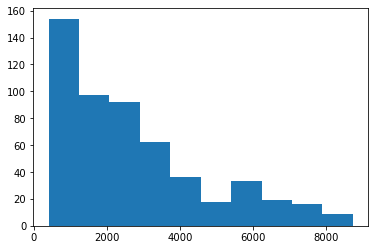

In [151]:
#distribucion de las ventas de los vendedores seleccionados
ventas = prueba["completed"]
ventas = ventas[ventas.between(ventas.quantile(.15), ventas.quantile(.85))]
(n, bins, patches) = plt.hist(ventas, bins=10, label='hist')

plt.show()

In [21]:
bins
bins = bins.tolist()

In [152]:
bins[0] = bins[0]-1
bins

array([ 407. , 1239.8, 2071.6, 2903.4, 3735.2, 4567. , 5398.8, 6230.6,
       7062.4, 7894.2, 8726. ])

In [157]:
labels = list(range(1, 11))
prueba_subset.loc[:,'binned'] = pd.cut(prueba_subset['completed'], bins=bins, labels=labels)
prueba_subset.head()

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


,id,nickname,permalink,registration_date,level_id,power_seller_status,canceled,total,completed,negative,neutral,positive,last_period,last_completed,binned
0,323005693,STREETGAMINGSTORE,http://perfil.mercadolibre.com.co/STREETGAMING...,2018-05-21T04:53:05.000-04:00,5_green,platinum,65,1845,1780,0.00,0.00,1.00,60 days,313,2
0,254779222,DRONES LUXURY,http://perfil.mercadolibre.com.co/DRONES+LUXURY,2017-04-30T23:07:37.000-04:00,5_green,platinum,102,3356,3254,0.01,0.01,0.98,60 days,746,4
0,76085013,OFERTA USA,http://perfil.mercadolibre.com.co/OFERTA+USA,2004-10-05T20:08:36.000-04:00,5_green,platinum,169,6606,6437,0.02,0.01,0.97,60 days,790,8
0,748090828,SUPERTECNOLOGIAYMASBARRANQUILL,http://perfil.mercadolibre.com.co/SUPERTECNOLO...,2021-04-22T16:50:55.000-04:00,4_light_green,None,99,936,837,0.05,0.05,0.90,60 days,162,1
0,205606809,TEKNOPOLISCOLOMBIA,http://perfil.mercadolibre.com.co/TEKNOPOLISCO...,2016-02-10T10:10:34.000-04:00,5_green,platinum,491,6791,6300,0.04,0.04,0.92,60 days,1113,8


In [158]:
prueba_subset['binned'].unique()

[2, 4, 8, 1, 9, 3, 10, 5, 7, 6]
Categories (10, int64): [1 < 2 < 3 < 4 ... 7 < 8 < 9 < 10]

In [159]:
dict_level = {None:0, '1_red':1, '2_orange':2, '3_yellow':3,
              '4_light_green': 4, '5_green':5}
dict_powerss = {None:0, 'silver': 1, 'platinum': 2, 'gold': 3} 
dict_period = {'365 days': 1, '60 days': 2} 

In [160]:
prueba_2 = prueba_subset.replace({"level_id": dict_level})
prueba_2 = prueba_2.replace({"power_seller_status": dict_powerss})
prueba_2 = prueba_2.replace({"last_period": dict_period})
prueba_2.head(2)

,id,nickname,permalink,registration_date,level_id,power_seller_status,canceled,total,completed,negative,neutral,positive,last_period,last_completed,binned
0,323005693,STREETGAMINGSTORE,http://perfil.mercadolibre.com.co/STREETGAMING...,2018-05-21T04:53:05.000-04:00,5,2,65,1845,1780,0.00,0.00,1.00,2,313,2
0,254779222,DRONES LUXURY,http://perfil.mercadolibre.com.co/DRONES+LUXURY,2017-04-30T23:07:37.000-04:00,5,2,102,3356,3254,0.01,0.01,0.98,2,746,4


In [161]:
df = prueba_2.iloc[:,4:]
#df = df.drop(columns = "completed")
df.head()

,level_id,power_seller_status,canceled,total,completed,negative,neutral,positive,last_period,last_completed,binned
0,5,2,65,1845,1780,0.00,0.00,1.00,2,313,2
0,5,2,102,3356,3254,0.01,0.01,0.98,2,746,4
0,5,2,169,6606,6437,0.02,0.01,0.97,2,790,8
0,4,0,99,936,837,0.05,0.05,0.90,2,162,1
0,5,2,491,6791,6300,0.04,0.04,0.92,2,1113,8


In [162]:
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

,level_id,power_seller_status,canceled,total,completed,negative,neutral,positive,last_period,last_completed
level_id,1.000000,0.350629,0.037313,0.065653,0.066569,-0.098104,-0.053633,0.097604,-0.015401,0.078465
power_seller_status,0.350629,1.000000,0.031031,0.076126,0.077856,-0.018520,0.015730,0.007562,0.257733,0.043770
canceled,0.037313,0.031031,1.000000,0.832264,0.815102,0.312010,0.216979,-0.329914,0.085582,0.659293
total,0.065653,0.076126,0.832264,1.000000,0.999542,0.106882,0.116479,-0.130726,0.106236,0.826117
completed,0.066569,0.077856,0.815102,0.999542,1.000000,0.094654,0.109872,-0.118593,0.106342,0.827282
negative,-0.098104,-0.018520,0.312010,0.106882,0.094654,1.000000,0.370046,-0.920673,0.041674,0.118511
neutral,-0.053633,0.015730,0.216979,0.116479,0.109872,0.370046,1.000000,-0.703318,0.018361,0.086125
positive,0.097604,0.007562,-0.329914,-0.130726,-0.118593,-0.920673,-0.703318,1.000000,-0.039603,-0.126870
last_period,-0.015401,0.257733,0.085582,0.106236,0.106342,0.041674,0.018361,-0.039603,1.000000,-0.044217
last_completed,0.078465,0.043770,0.659293,0.826117,0.827282,0.118511,0.086125,-0.126870,-0.044217,1.000000


In [163]:
df = df.drop(columns = ["completed", "total", "negative"])
df.head()

,level_id,power_seller_status,canceled,neutral,positive,last_period,last_completed,binned
0,5,2,65,0.00,1.00,2,313,2
0,5,2,102,0.01,0.98,2,746,4
0,5,2,169,0.01,0.97,2,790,8
0,4,0,99,0.05,0.90,2,162,1
0,5,2,491,0.04,0.92,2,1113,8


## 3. Modelo

## Training y test

In [164]:
df.isna().sum()

level_id               0
power_seller_status    0
canceled               0
neutral                0
positive               0
last_period            0
last_completed         0
binned                 0
dtype: int64

In [165]:
y = df["binned"]
x = df.drop(columns = "binned")
x.head(2)

,level_id,power_seller_status,canceled,neutral,positive,last_period,last_completed
0,5,2,65,0.00,1.00,2,313
0,5,2,102,0.01,0.98,2,746


In [166]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.10)

In [167]:
len(y_train)

482

In [168]:
len(y_test)

54

## Ridge classifier

In [169]:
scaler = StandardScaler()

In [170]:
x_train.head(2)

,level_id,power_seller_status,canceled,neutral,positive,last_period,last_completed
0,5,2,313,0.03,0.93,2,1460
0,5,3,20,0.02,0.92,2,255


In [171]:
x_train_s = scaler.fit_transform(x_train)
x_test_s = scaler.transform(x_test)

In [172]:
rgc = RidgeClassifier(alpha=100, random_state=42)

In [173]:
rgc.fit(x_train_s,y_train)

RidgeClassifier(alpha=100, random_state=42)

In [174]:
y_pred_rgc = rgc.predict(x_test_s)

In [175]:
rgc.score(x_test_s, y_test)

0.37037037037037035

In [176]:
from sklearn.metrics import accuracy_score

In [177]:
accuracy_score(y_test, y_pred_rgc)

0.37037037037037035

In [119]:
#print(f'Decision tree clasifier: {round(rfc.score(x_test, y_test)*100,0)}%')

In [179]:
import statistics

In [180]:
statistics.mode(df['binned'])
statistics.mode(y_train)

1

In [181]:
from sklearn.metrics import accuracy_score

In [182]:
guess = statistics.mode(y_train)
y_pred_base = [guess]*len(y_test)

In [183]:
score = accuracy_score(y_test, y_pred_base)
print(f'Baseline accuracy score {round(score*100, 0)}' )

Baseline accuracy score 31.0


## Random Forest Classifier

In [184]:
y_train[:5]

0    7
0    1
0    3
0    1
0    8
Name: binned, dtype: category
Categories (10, int64): [1 < 2 < 3 < 4 ... 7 < 8 < 9 < 10]

In [185]:
from sklearn.ensemble import RandomForestClassifier

In [186]:
rfc = RandomForestClassifier(random_state = 42)

In [187]:
rfc.fit(x_train, y_train)

RandomForestClassifier(random_state=42)

In [188]:
y_pred_rfc = rfc.predict(x_test)
y_pred_rfc[:5]

array([1, 1, 4, 5, 1])

In [189]:
rfc.score(x_test, y_test)

0.5740740740740741

In [190]:
accuracy_score(y_test, y_pred_rfc)

0.5740740740740741

In [191]:
rfc.feature_importances_

array([0.00537761, 0.05702671, 0.36320164, 0.08615627, 0.14037002,
       0.00520864, 0.34265912])